# Neural Network Autoencoder in Numpy

This is an example of an autoencoder written in Numpy.  It has 1 hidden layer of a given size.  I have tied the weights of the hidden->output layer to that of the input->hidden layer.  I won't go into what an autoencoder is, but thought I would post basic Numpy code for it.

First, we have to import a few libraries.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

# Define the Autoencoder class

Here I will define the class, where the constructor takes the number of units to have in the hidden layer.

In [16]:
class AutoEncoderNumpy(object):
    def __init__(self, M):
        self.M = M
        
    # generate gaussian weights with shape = shape
    def init_weights(self, shape):
        return np.random.randn(*shape) / np.sqrt(np.sum(shape))

    # fit function that uses gradient descent with momentum
    # X = data
    # epochs = # of training epochs
    # lr = learning rate
    # momentum = momentum to use during learning
    def fit(self, X, epochs=10, lr=0.1, momentum=0.9):
        N, D = X.shape
        # setup all the weights with initial values
        self.W0 = self.init_weights((D, self.M))
        self.b0 = np.zeros(self.M)
        self.b1 = np.zeros(D)
        # setup variables needed to implement momentum gradient descent
        self.dW0 = np.zeros(self.W0.shape)
        self.db0 = np.zeros(self.M)
        self.db1 = np.zeros(D)
        # keep track of costs vs. epoch
        self.costs = []
        for i in xrange(epochs):
            Z, pX = self.forward(X)  # pX = predicted X of autoencoder
            cost = (0.5*(X-pX)**2).mean()
            self.costs.append(cost)
            if i % 500 == 0:
                print 'Epoch %i of %i, cost = %s' % (i, epochs, self.costs[-1])
            # do updates
            self.W0 = self.W0 + momentum * self.dW0 - lr * self.grad_W0(X, pX, Z, self.W0)
            self.b0 = self.b0 + momentum * self.db0 - lr * self.grad_b0(X, pX, Z, self.W0)
            self.b1 = self.b1 + momentum * self.db1 - lr * self.grad_b1(X, pX)
            self.dW0 = momentum * self.dW0 - lr * self.grad_W0(X, pX, Z, self.W0)
            self.db0 = momentum * self.db0 - lr * self.grad_b0(X, pX, Z, self.W0)
            self.db1 = momentum * self.db1 - lr * self.grad_b1(X, pX)

    # gradient for calculating W0 update
    def grad_W0(self, X, pX, Z, W0):
        dZ = -1 * (X - pX).dot(W0) * Z * (1 - Z)
        return X.T.dot(dZ)

    # gradient for calculating b0 update
    def grad_b0(self, X, pX, Z, W0):
        return (-1 * (X - pX).dot(W0) * Z * (1 - Z)).sum(axis=0)

    # gradient for calculating b1 update
    def grad_b1(self, X, pX):
        return (-1*(X - pX)).sum(axis=0)

    # sigmoid function used for hidden layer
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

    # function to encode the inputs
    def forward_encode_only(self, X):
        return self.sigmoid(X.dot(self.W0) + self.b0)

    # function to encode then decode the inputs
    def forward(self, X):
        Z = self.sigmoid(X.dot(self.W0) + self.b0)
        Y = Z.dot(self.W0.T) + self.b1
        return Z, Y

    # function to plot out the incoming data, the encoded data,
    # the decoded data, and the cost function vs. epochs
    def plot_debug(self, X, Y):
        encoder_output = self.forward_encode_only(X)
        _, predicted = self.forward(X)
        ax = plt.subplot(2,2,1)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_title('Incoming Data')
        plt.scatter(X[:,0], X[:,1], c=Y, s=100, alpha=0.5)
        ax = plt.subplot(2,2,2)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_title('Encoded Data')
        plt.scatter(encoder_output[:,0], encoder_output[:,1], c=Y, s=100, alpha=0.5)
        ax = plt.subplot(2,2,3)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_title('Decoded Data')
        plt.scatter(predicted[:,0], predicted[:,1], c=Y, s=100, alpha=0.5)
        ax = plt.subplot(2,2,4)
        ax.set_title('Cost vs. epoch')
        plt.plot(self.costs)
        plt.tight_layout()
        plt.show()

# Test function

This function simply loads an simple example data file with 4 features (2 of them are correlated to another).  Ideally we should be able to run this through an autoencoder and reproduce most of the data with only 2 columns.

In [17]:
def TestAutoEncoderNumpy():
    # Load simple example data, randomize the order, and then scale every
    # feature to between 0 & 1.  This example is 2 donuts at different radii
    # (and noise around them) with 2 columns that are correlated.  An
    # autoencoder (among other techniques) should be able to reduce this down
    # to 2 significant features instead of the original 4.
    data = np.load('../../data/donut_corr2.npy')
    data = shuffle(data, random_state=147)  # random_state set for testing
    Xtrain = data[:, :-1].astype(np.float32)
    Ytrain = data[:, -1].astype(np.int64)
    Xtrain = MinMaxScaler((0, 1)).fit_transform(Xtrain)
    # setup autoencoder input (4) -> hidden (2) -> output (4) for example input
    # pass number of hidden layers
    ae = AutoEncoderNumpy(2)
    ae.fit(Xtrain, lr=0.00001, momentum=0.9, epochs=5000)
    ae.plot_debug(Xtrain, Ytrain)

# Test the autoencoder

Run the test.  I didn't spend a lot of time optimizing this, but you can see in the plots below it does a decent job of reproducing the input (now with 2 features instead of the original 4).

Epoch 0 of 5000, cost = 0.188062518539
Epoch 500 of 5000, cost = 0.000574126595509
Epoch 1000 of 5000, cost = 0.000418558210906
Epoch 1500 of 5000, cost = 0.000414104451906
Epoch 2000 of 5000, cost = 0.000412956131664
Epoch 2500 of 5000, cost = 0.000412943319804
Epoch 3000 of 5000, cost = 0.000413518635896
Epoch 3500 of 5000, cost = 0.000414404531105
Epoch 4000 of 5000, cost = 0.000415453882331
Epoch 4500 of 5000, cost = 0.000416589138731


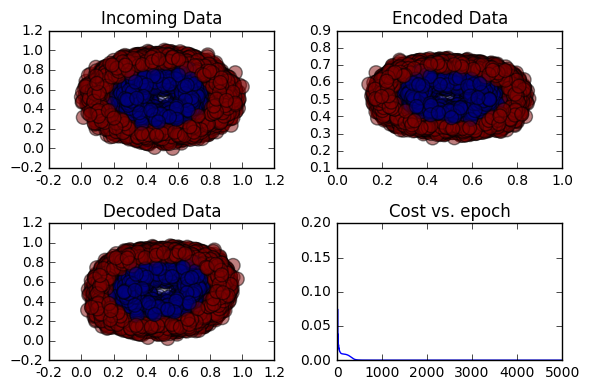

In [19]:
TestAutoEncoderNumpy()